# Load model and data

In [ ]:
# change work dir
import os

os.chdir("/Your/path/to/Eva")

import matplotlib.pyplot as plt
import numpy as np
import torch
from omegaconf import OmegaConf

from Eva.utils import create_model, extract_features, load_from_hf

In [69]:
%%time
# Load configuration
conf = OmegaConf.load("config.yaml")

# Load model from HuggingFace Hub, will download from HF for the first time
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_from_hf(
    repo_id="yandrewl/Eva",
    conf=conf,
    device=device
)
# print(model)  # check model architecture

Checkpoint downloaded to: /home/yfliu/.cache/huggingface/hub/models--yandrewl--Eva/snapshots/5dac7105ba22c347a1f76e931576123e08fe50f7/Eva_model.ckpt
Model loaded successfully from HuggingFace Hub
CPU times: user 10.2 s, sys: 2.98 s, total: 13.2 s
Wall time: 19.5 s


In [77]:
# Load examples of H&E and MIF patches with size of 224*224
mif_patch = np.load("examples/MIF_patch.npy")
he_patch = np.load("examples/HE_patch.npy") / 255.0
biomarkers = np.load("examples/biomarkers.npy", allow_pickle=True).tolist()

print(biomarkers)

['CD4', 'CD45', 'Keratin8/18', 'CollagenIV', 'TIGIT', 'LAG3', 'CD14', 'CD34', 'Gal3', 'FoxP3', 'CD45RO', 'PCNA', 'PDL1', 'ICOS', 'HLA-DR', 'PanCK', 'Podoplanin', 'Caveolin1', 'CD39', 'aSMA', 'IDO1', 'PD1', 'BCL2', 'CD40', 'Ki67', 'TP63', 'CD141', 'CD20', 'GATA3', 'ECad', 'Vimentin', 'CD11c', 'CD21', 'CD163', 'CD44', 'IFNg', 'EpCAM', 'MPO', 'DAPI', 'CD31', 'CD66', 'HLA-E', 'GranzymeB', 'ATM', 'ERa', 'CD68', 'CD8', 'VISTA', 'CD3e', 'CD38', 'CD79', 'HLA-ABC']


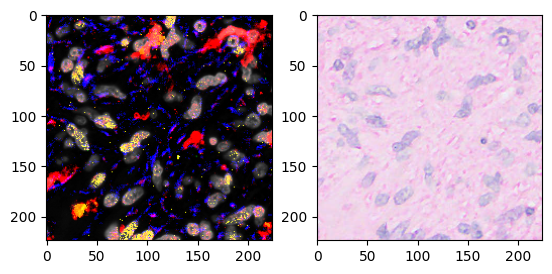

In [78]:
# visualize MIF patch
from utils.overlay import compose_overlay

overlay = compose_overlay(mif_patch, [biomarkers.index("DAPI"), 1, 2, 3 ,4 ], colors=["gray", "red", "blue", "green", "yellow"])  
# here we move DAPI to the first one.
# for check compose_overlay for customized function usage
fig, ax = plt.subplots(1, 2) 
ax[0].imshow(overlay)
ax[1].imshow(he_patch.astype(np.float32))

# Embedding generation with Eva

Note: `channel_mode` controls multi-modality input. For multi-modal input, append H&E as the last three channels. If the data has only one modality, set `channel_mode="full"`.

In [80]:
%%time
# 1. MIF embedding
features = extract_features(
    patch=torch.from_numpy(mif_patch).unsqueeze(0),  # shape as [B, H, W, C]
    bms=[biomarkers],  # List of biomarker lists (one per batch item)
    model=model,
    device=device,
    cls=False,  # Use CLS token (True) or averaged token (False)
    channel_mode="full"  
)
print(features.shape)

torch.Size([1, 768])
CPU times: user 790 ms, sys: 6.25 ms, total: 796 ms
Wall time: 28.9 ms


In [81]:
%%time
# 2. MIF with model method
features = model.extract_features(
    patch=torch.from_numpy(mif_patch).unsqueeze(0),
    bms=[biomarkers],
    device=device,
    cls=False, 
    channel_mode="full"
)
print(features.shape)

torch.Size([1, 768])
CPU times: user 733 ms, sys: 0 ns, total: 733 ms
Wall time: 27.4 ms


In [82]:
%%time
# 3. H&E embedding
features = extract_features(
    patch=torch.from_numpy(he_patch).unsqueeze(0),  # shape as [B, H, W, C]
    bms=[["HECHA1", "HECHA2", "HECHA3"]],  # refer to constant for detailed marker names
    device=device,
    model=model,
    cls=False,
    channel_mode="full"
)
print(features.shape)

torch.Size([1, 768])
CPU times: user 623 ms, sys: 0 ns, total: 623 ms
Wall time: 13.4 ms


In [84]:
%%time
# 4. Multi-model embedding
features = extract_features(
    patch=torch.from_numpy(np.concatenate([mif_patch, he_patch], axis=-1)).unsqueeze(0),  
    bms=[biomarkers +["HECHA1", "HECHA2", "HECHA3"]],
    device=device,
    model=model,
    cls=False,
    channel_mode="HE"  # Options: "full", "HE", "MIF", this option determine modality by their ORDER, i.e. the last three are H&E
)
print(features.shape)

torch.Size([1, 768])
CPU times: user 763 ms, sys: 4.79 ms, total: 767 ms
Wall time: 19.4 ms
